In [9]:
import numpy as np 
from scipy.special import comb

In [10]:
base_error = np.linspace(0, 1, 20)

In [11]:
base_error

array([0.        , 0.05263158, 0.10526316, 0.15789474, 0.21052632,
       0.26315789, 0.31578947, 0.36842105, 0.42105263, 0.47368421,
       0.52631579, 0.57894737, 0.63157895, 0.68421053, 0.73684211,
       0.78947368, 0.84210526, 0.89473684, 0.94736842, 1.        ])

In [24]:
y = []
for epsilon in base_error:
    # 注意scipy.special.comb的使用方法
    ensemble_error = np.array([comb(25, i) * (epsilon ** i) * ((1 - epsilon) ** (25 - i)) for i in range(13, 26)]).sum()
    y.append(ensemble_error)

In [25]:
import matplotlib.pyplot as plt 

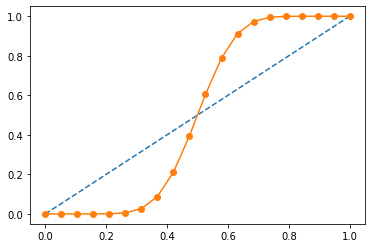

In [26]:
fig, ax = plt.subplots()
ax.plot(base_error, base_error, '--')
ax.plot(base_error, y, 'o-')

In [37]:
from sklearn.datasets import load_boston
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
import pandas as pd

In [38]:
boston = load_boston()

In [39]:
X_full, y_full = boston.data, boston.target

In [40]:
rng = np.random.RandomState(0)

In [43]:
missing_rate = 0.5
n_samples = X_full.shape[0]
n_features = X_full.shape[1]
n_missing_samples = int(np.floor(n_samples * missing_rate * n_features))

In [44]:
missing_samples = rng.randint(0, n_samples, n_missing_samples)
missing_features = rng.randint(0, n_features, n_missing_samples)

In [45]:
X_missing = X_full.copy()
X_missing[missing_samples, missing_features] = np.nan

In [46]:
pd.DataFrame(X_missing).isnull().sum()

0     200
1     193
2     189
3     196
4     202
5     206
6     214
7     182
8     199
9     200
10    206
11    211
12    203
dtype: int64

In [47]:
# 用 0 填补空缺值


X_missing_0 = X_missing.copy()
X_missing_0 = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0).fit_transform(X_missing_0)

In [48]:
pd.DataFrame(X_missing_0).isnull().sum()

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
dtype: int64

In [50]:
# 用 平均值 填补空缺值

X_missing_mean = X_missing.copy()
X_missing_mean = SimpleImputer(missing_values=np.nan, strategy='mean').fit_transform(X_missing_mean)

In [51]:
pd.DataFrame(X_missing_mean).isnull().sum()

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
dtype: int64

In [56]:
# 用 随机森林回归 填补空缺值

X_missing_reg = X_missing.copy()
X_missing_reg = pd.DataFrame(X_missing_reg)

In [57]:
feature_idx = np.argsort(pd.DataFrame(X_missing_reg).isnull().sum())

In [62]:
for i in feature_idx:
    df = X_missing_reg
    # 1\ 新标签
    fillc = df.iloc[:, i]
    # 2\ 新特征矩阵
    feature_matrix = pd.concat([df.loc[:, df.columns != i], pd.DataFrame(y_full)], axis=1)
    feature_matrix_0 = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0).fit_transform(feature_matrix)
    # 3\ 训练集
    y_train = fillc.loc[fillc.notnull()]
    y_test = fillc.loc[fillc.isnull()]
    
    X_train = feature_matrix_0[y_train.index, :]
    X_test = feature_matrix_0[y_test.index, :]
    
    # 4\ 填充fillc
    reg = RandomForestRegressor(n_estimators=100)
    reg.fit(X_train, y_train)
    y_predict = reg.predict(X_test)
    X_missing_reg.loc[X_missing_reg.iloc[:, i].isnull(), i] = y_predict 

In [64]:
X_missing_reg.isnull().sum()

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
dtype: int64

In [65]:
from sklearn.model_selection import cross_val_score

In [66]:
X = [X_full, X_missing_0, X_missing_mean, X_missing_reg]
mse = []
for x in X:
    reg = RandomForestRegressor(n_estimators=100)
    score = cross_val_score(reg, x, y_full, scoring='neg_mean_squared_error', cv=5).mean()
    mse.append(score * (-1))

[21.998514494777694, 46.95815318344012, 42.112378985245584, 17.297813994428257]

In [67]:
# 将 特征矩阵 与其 对应的mse 以元组形式输出

[*zip(['X_full', 'X_missing_0', 'X_missing_mean', 'X_missing_reg'], mse)]

[('X_full', 21.998514494777694),
 ('X_missing_0', 46.95815318344012),
 ('X_missing_mean', 42.112378985245584),
 ('X_missing_reg', 17.297813994428257)]

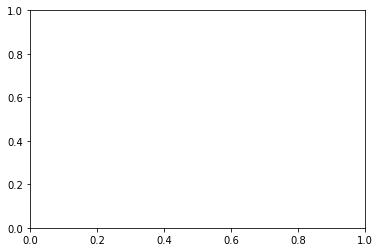

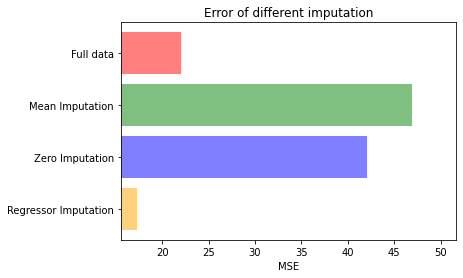

In [74]:
fig, ax = plt.subplots()

x_labels = ['Full data'
           ,'Mean Imputation'
           ,'Zero Imputation'
           ,'Regressor Imputation']

colors = ['r', 'g', 'b', 'orange']

fig, ax = plt.subplots()
for i in range(len(mse)):
    ax.barh(i, mse[i], color=colors[i], alpha=0.5, align='center')

ax.set_title('Error of different imputation')
ax.set_xlim(left=min(mse) * 0.9, right=max(mse) * 1.1)
ax.set_xlabel('MSE')

ax.set_yticks(np.arange(len(mse)))
ax.set_yticklabels(x_labels)

ax.invert_yaxis()